# Completion profiling

Profiling avec [cProfile](https://docs.python.org/3.7/library/profile.html), [memory_profiler](https://pypi.org/project/memory-profiler/), [pyinstrument](https://github.com/joerick/pyinstrument), [snakeviz](https://jiffyclub.github.io/snakeviz/).

[line_profiler](https://github.com/rkern/line_profiler) ne semble pas plus être maintenu.

In [1]:
%matplotlib inline

## Setup

### Function to profile

In [2]:
from mlstatpy.nlp.completion import CompletionTrieNode


def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

### Data

In [3]:
from mlstatpy.data.wikipedia import download_titles

file_titles = download_titles(country="fr")

In [4]:
len(file_titles)

33

In [5]:
from mlstatpy.data.wikipedia import enumerate_titles

list_titles = list(
    sorted(set(_ for _ in enumerate_titles(file_titles) if "A" <= _[0] <= "Z"))
)

In [6]:
import random

sample1000 = random.sample(list_titles, 1000)
with open("sample1000.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(sample1000))

## Standard modules

### cProfile

In [7]:
import cProfile, io, pstats, os


def toprofile0(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))


def doprofile(lines, filename):
    pr = cProfile.Profile()
    pr.enable()
    toprofile0(lines)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats("cumulative")
    ps.print_stats()
    rem = os.path.normpath(os.path.join(os.getcwd(), "..", "..", ".."))
    res = s.getvalue().replace(rem, "")
    ps.dump_stats(filename)
    return res

In [8]:
r = doprofile(sample1000, "completion.prof")
print(r)

         1289418 function calls in 1.487 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.487    1.487 /tmp/ipykernel_54937/4045418276.py:4(toprofile0)
        1    0.075    0.075    1.487    1.487 /tmp/ipykernel_54937/1707536480.py:4(gain_dynamique_moyen_par_mot)
        1    0.314    0.314    1.107    1.107 /mlstatpy/nlp/completion.py:442(precompute_stat)
    16034    0.167    0.000    0.652    0.000 /mlstatpy/nlp/completion.py:531(merge_completions)
    16034    0.308    0.000    0.319    0.000 {built-in method builtins.__build_class__}
        1    0.055    0.055    0.204    0.204 /mlstatpy/nlp/completion.py:477(update_stat_dynamic)
    36051    0.081    0.000    0.094    0.000 /mlstatpy/nlp/completion.py:554(<listcomp>)
    17034    0.046    0.000    0.088    0.000 /mlstatpy/nlp/completion.py:594(update_dynamic_minimum_keystroke)
        1    0.045    0.045    0.075    0.075 /mlstatpy/

## Others informations when profiling

### memory_profiler

See [memory_profiler](https://pypi.python.org/pypi/memory_profiler/0.41). Version 0.56 is bugged (see [#258](https://github.com/pythonprofilers/memory_profiler/issues/258)).

In [10]:
from memory_profiler import profile

%load_ext memory_profiler

In [11]:
%memit toprofile0(sample1000)

peak memory: 547.55 MiB, increment: 0.00 MiB


In [12]:
from io import StringIO

st = StringIO()


@profile(stream=st)
def toprofile(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))


toprofile(sample1000)

ERROR: Could not find file /tmp/ipykernel_54937/1913397401.py


In [13]:
%%file temp_mem_profile.py

from mlstatpy.nlp.completion import CompletionTrieNode
from memory_profiler import profile


@profile(precision=4)
def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length


@profile(precision=4)
def toprofile():
    with open("sample1000.txt", "r", encoding="utf-8") as f:
        lines = [_.strip("\n\r ") for _ in f.readlines()]
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))


toprofile()

Writing temp_mem_profile.py


In [14]:
import sys

cmd = sys.executable
from sphinx_runpython.runpython import run_cmd

cmd += " -m memory_profiler temp_mem_profile.py"
out, err = run_cmd(cmd, wait=True)
print(out)

Filename: temp_mem_profile.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     6  45.8438 MiB  45.8438 MiB           1   @profile(precision=4)
     7                                         def gain_dynamique_moyen_par_mot(queries, weights):
     8  45.8438 MiB   0.0000 MiB           1       per = list(zip(weights, queries))
     9  45.8438 MiB   0.0000 MiB           1       total = sum(weights) * 1.0
    10  45.8438 MiB   0.0000 MiB           1       res = []
    11  52.5469 MiB   6.7031 MiB        1003       trie = CompletionTrieNode.build([(None, q) for _, q in per])
    12  60.0234 MiB   7.4766 MiB           1       trie.precompute_stat()
    13  69.5625 MiB   9.5391 MiB           1       trie.update_stat_dynamic()
    14  69.5625 MiB   0.0000 MiB        1003       wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    15  69.5625 MiB   0.0000 MiB        1003       wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    1

## Static Visualization

### pyinstrument

See [pyinstrument](https://github.com/joerick/pyinstrument).

In [16]:
from pyinstrument import Profiler

profiler = Profiler()
profiler.start()

toprofile0(sample1000)

profiler.stop()
out = profiler.output_text(unicode=False, color=False)
print(out.replace("\\", "/"))


  _     ._   __/__   _ _  _  _ _/_   Recorded: 12:44:24  Samples:  862
 /_//_/// /_/ / //_// / //_'/ //     Duration: 1.340     CPU time: 1.345
/   _/                      v4.7.3

Profile at /tmp/ipykernel_54937/259320473.py:4

1.338 ZMQInteractiveShell.run_ast_nodes  IPython/core/interactiveshell.py:3418
`- 1.337 <module>  ../../../tmp/ipykernel_54937/259320473.py:1
   `- 1.337 toprofile0  ../../../tmp/ipykernel_54937/4045418276.py:4
      `- 1.337 gain_dynamique_moyen_par_mot  ../../../tmp/ipykernel_54937/1707536480.py:4
         |- 0.683 CompletionTrieNode.precompute_stat  mlstatpy/nlp/completion.py:442
         |  |- 0.467 _Stat.merge_completions  mlstatpy/nlp/completion.py:531
         |  |  |- 0.236 [self]  mlstatpy/nlp/completion.py
         |  |  |- 0.110 __build_class__  <built-in>
         |  |  `- 0.076 <listcomp>  mlstatpy/nlp/completion.py:554
         |  |     `- 0.068 [self]  mlstatpy/nlp/completion.py
         |  |- 0.126 [self]  mlstatpy/nlp/completion.py
         |  

## Javascript Visualization

### SnakeViz

In [17]:
%load_ext snakeviz

L'instruction qui suit lance l'explorateur par défaut avec les données du profilage.

In [16]:
# %snakeviz toprofile0(sample1000)

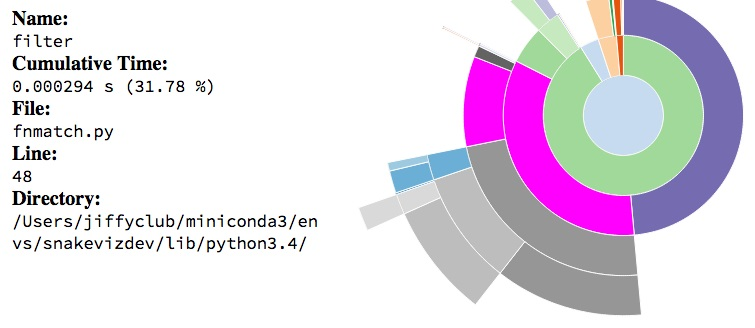

In [19]:
from IPython.display import Image

Image("images/func_info.jpg", width=400)

### vprof, py-spy

See [vprof](https://github.com/nvdv/vprof) or [py-spy](https://github.com/benfred/py-spy). The second one outputs a SVG file easy to handle.

In [18]:
# from vprof import profiler

# needs to be run from a file not from a notebook
# profiler.run(toprofile0, 'cmh', args=(sample1000,), host='localhost', port=8000)

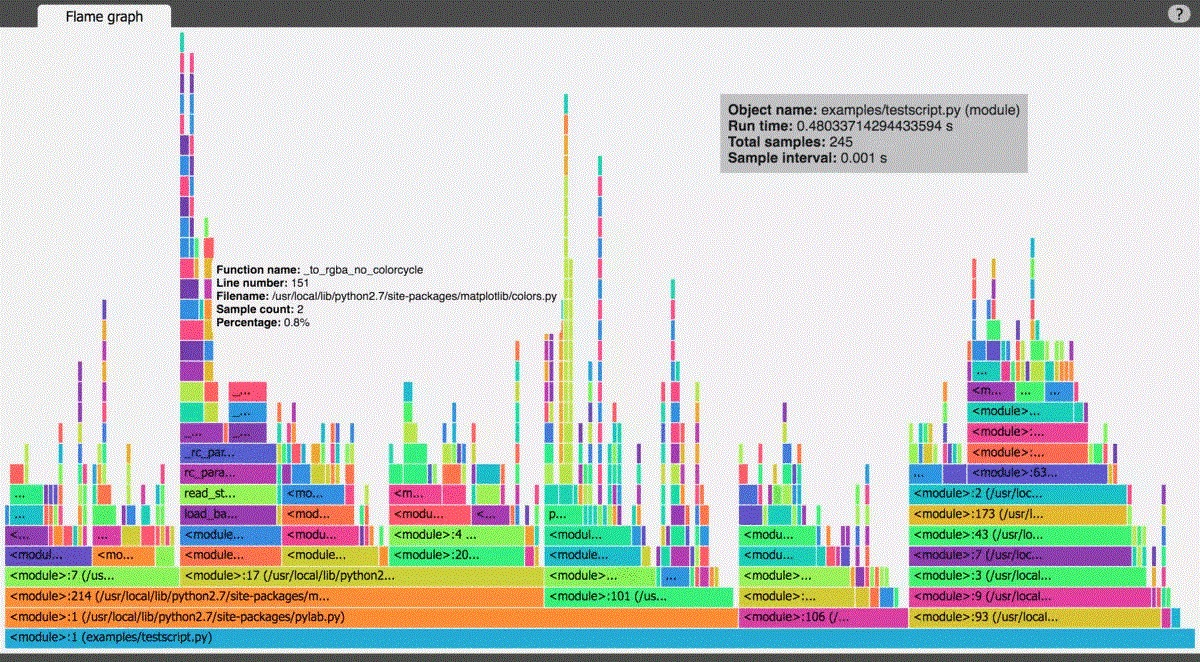

In [20]:
from IPython.display import Image

Image("images/vprof.jpg", width=800)